In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
import numpy.lib.recfunctions
import scipy
from healpy import npix2nside
import healpy as hp

import seaborn as sns
sns.set_style("whitegrid")
plt = sns.mpl.pyplot


import glob
import sys
from socket import gethostname
from os.path import join
sys.path.append("/home/lschumacher/svn_repos/skylab/trunk/doc/analyses/lschumacher-UHECR/")
print(gethostname())


import ic_utils as utils
savepath, crpath, figurepath = utils.get_paths(gethostname())
print savepath
print figurepath


from prior_scan import ScrambledPriorScan
from prior_generator import UhecrPriorGenerator
from skylab.priors import SpatialPrior


print ":)"

cobalt03.icecube.wisc.edu
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged
/home/lschumacher/public_html/uhecr_stacking/hotspot_fit/merged
:)


## testing

In [32]:
map_dtype = [('dec', '<f8'), ('theta', '<f8'), ('ra', '<f8'), ('TS', '<f8'), ('pVal', '<f8')]

In [33]:
nsideparam = 3
nside = 2**nsideparam
npix = hp.nside2npix(nside)

In [34]:
simple_prior = np.zeros(npix)

disc_pix = hp.query_disc(nside, hp.ang2vec(np.pi/2, np.pi), np.radians(20))
simple_prior[disc_pix] = 1
#simple_prior[hp.ang2pix(nside, np.pi/2, np.pi)] = 1

In [35]:
simple_scan = np.zeros(npix, dtype=map_dtype)
            
simple_scan["theta"], simple_scan["ra"] = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
simple_scan["dec"] = np.pi/2. - simple_scan["theta"]
simple_scan[hp.ang2pix(nside, np.pi/2, np.pi)]["TS"] = 15
simple_scan[hp.ang2pix(nside, np.pi/2, np.pi)]["pVal"] = 15

random_pix = np.random.choice(np.arange(npix), size=25)
random_TS_val = np.random.uniform(low=2, high=15, size=25)
simple_scan["TS"][random_pix] += random_TS_val
simple_scan["pVal"][random_pix] += random_TS_val


(<Figure size 576x396 with 2 Axes>,
 <matplotlib.axes._subplots.AitoffAxesSubplot at 0x7f11112480d0>)

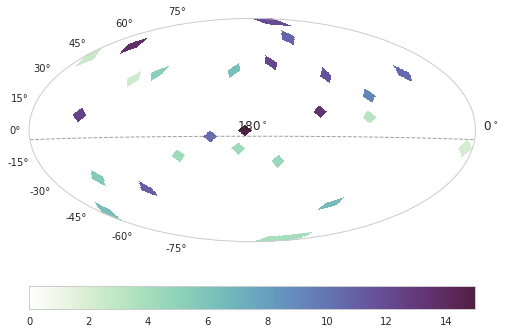

In [36]:
utils.skymap(plt, simple_scan["TS"], cmap=utils.cmap_r)

In [37]:
simple_prior_obj = SpatialPrior([simple_prior])

wspot_scrambler = ScrambledPriorScan(simple_scan, simple_prior_obj)

(<Figure size 576x396 with 2 Axes>,
 <matplotlib.axes._subplots.AitoffAxesSubplot at 0x7f11111c9d90>)

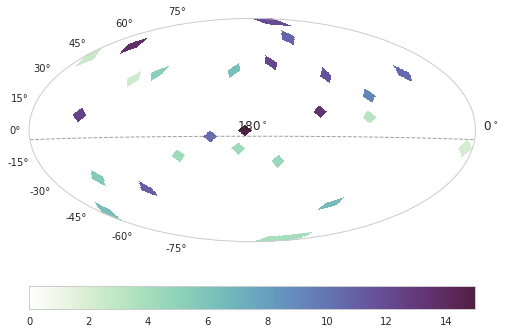

In [38]:
utils.skymap(plt, wspot_scrambler.original_scan["TS"], cmap=utils.cmap_r)

In [39]:
wspot_scrambler.original_hotspots

{'spatial_prior_0': {'grid': {'TS': 15.0,
   'dec': 0.0,
   'nside': 8,
   'pVal': 15.0,
   'pix': 384,
   'ra': 3.2397674240144743}}}

0
100
200
300
400
500
600
700
800
900


Text(0,0.5,'a.u.')

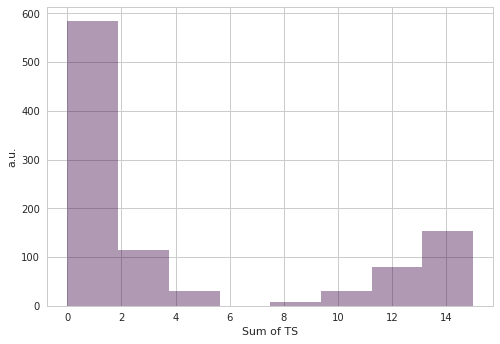

In [40]:
result, TS, original_TS_sum = wspot_scrambler.calculate_post_trial_pvalue(niter=1000, verbose=True)

plt.figure()
sns.distplot(TS, label="scrambled TS", kde=False)
#plt.axvline(original_TS_sum, label="Percentile of original TS: {}%".format(result))
plt.xlabel("Sum of TS")
plt.ylabel("a.u.")

## Pre selection of scans that are at +3sigma threshold

In [41]:
identifier = "ic-ant-scan"

nsideparam = 8
nside = 2**nsideparam
npix = hp.nside2npix(nside)

wspot_dict = {"70": {"TS": 1043, "mu": 2},
              "85": {"TS": 314, "mu": 2},
              "100": {"TS": 176, "mu": 4}
             }
mdparams = 6

for ecut in wspot_dict:
    pgen = UhecrPriorGenerator(nsideparam)
    p_template = pgen.calc_template(np.radians(mdparams), 
                                    float(ecut), 
                                    crpath, 
                                    files=["AugerUHECR2014.txt", "TelArrayUHECR.txt"]
                                   )
    wspot_dict[ecut]["prior"] = SpatialPrior(p_template)

for ecut in wspot_dict:
    files = sorted(glob.glob("/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/"\
                             +"signal_1531220158_{}_*_mdparams-6_ecut-{}_mu-{}_srcgamma-2.19_shift-0_nsamples-2/job-*_warmspots-*.npy".format(identifier, ecut, wspot_dict[ecut]["mu"])
                            ))
    for f in files:
        parts = f.split("/")
        path = "/".join(parts[:-1])
        id_parts = parts[-1].split(".")[0].split("_")
        for idp in id_parts:
            if "job-" in idp:
                job_id = idp.split("-")[-1]
            if "warmspots-" in idp:
                scan_id = idp.split("-")[-1]
        hotspot = utils.load_json_data(join(path, "job-{}_hotspot-{}.json".format(job_id, scan_id)))
        TS_sum = np.array([hotspot[hs]["grid"]["TS"] for hs in hotspot]).sum()
        if abs(TS_sum-wspot_dict[ecut]["TS"])/wspot_dict[ecut]["TS"]>0.05:
            continue
        else:
            print "loading a good data set"

            warmspot = np.load(f)
            if min(warmspot["TS"])>3:
                continue
            
            print "Found correctly cut warmspot map"
            
            warm_spot_map = np.zeros(npix, dtype=map_dtype)
            
            warm_spot_map["theta"], warm_spot_map["ra"] = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
            warm_spot_map["dec"] = np.pi/2. - warm_spot_map["theta"]
            for sp in warmspot:
                pix = hp.ang2pix(nside, sp["theta"], sp["phi"])
                warm_spot_map[pix]["TS"] = sp["TS"]
                warm_spot_map[pix]["pVal"] = sp["TS"]
                
            print "instantiating a scrambler object"
            wspot_scrambler = ScrambledPriorScan(warm_spot_map, wspot_dict[ecut]["prior"])
            # test for deviations in calculated hotspots and original hotspots
            sp_keys = np.sort(wspot_scrambler.original_hotspots.keys())
            assert(np.all(sp_keys == np.sort(hotspot.keys())))
            relative_difference = ((sum([wspot_scrambler.original_hotspots[hs]["grid"]["TS"] for hs in sp_keys])\
                    - sum([hotspot[hs]["grid"]["TS"] for hs in sp_keys]))\
                    /sum([hotspot[hs]["grid"]["TS"] for hs in sp_keys]))
            
            
            if np.any(abs(relative_difference)>0.01):
                print "test for deviations was positive :("
                print relative_difference
                continue
            else:
                print "found a suiting warm spot map!"
                print "     *      *      *      *"
                wspot_dict[ecut]["warm_spot_map"] = np.copy(warm_spot_map)
                wspot_dict[ecut]["signal_TS"] = TS_sum
                wspot_dict[ecut]["scrambler"] = wspot_scrambler
                wspot_dict[ecut]["file"] = f
                break


loading a good data set
Found correctly cut warmspot map
instantiating a scrambler object
found a suiting warm spot map!
     *      *      *      *
loading a good data set
Found correctly cut warmspot map
instantiating a scrambler object
found a suiting warm spot map!
     *      *      *      *
loading a good data set
Found correctly cut warmspot map
instantiating a scrambler object
found a suiting warm spot map!
     *      *      *      *


In [48]:
for k in wspot_dict:
    print wspot_dict[k]['file']

/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1531220158_ic-ant-scan_3_mdparams-6_ecut-100_mu-4_srcgamma-2.19_shift-0_nsamples-2/job-0_warmspots-2.npy
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1531220158_ic-ant-scan_2_mdparams-6_ecut-85_mu-2_srcgamma-2.19_shift-0_nsamples-2/job-10_warmspots-0.npy
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1531220158_ic-ant-scan_1_mdparams-6_ecut-70_mu-2_srcgamma-2.19_shift-0_nsamples-2/job-0_warmspots-0.npy


[autoreload of skylab.base_llh failed: Traceback (most recent call last):
  File "/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: do_allsky_trials() requires a code object with 0 free vars, not 4
]


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7


KeyboardInterrupt: 

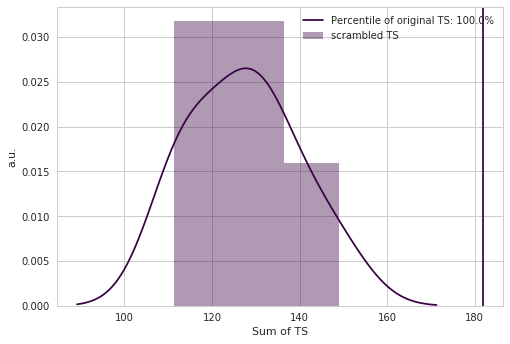

In [42]:
for ecut in wspot_dict:
    result, TS, original_TS_sum = wspot_dict[ecut]['scrambler'].calculate_post_trial_pvalue(niter=50, verbose=True)
    wspot_dict[ecut]['scrambling result'] = result
    wspot_dict[ecut]['original TS'] = original_TS_sum
    wspot_dict[ecut]['scrambling TS'] = TS
    try:
        plt.figure()
        sns.distplot(TS, label="scrambled TS")
        plt.axvline(original_TS_sum, label="Percentile of original TS: {}%".format(result))
        plt.xlabel("Sum of TS")
        plt.ylabel("a.u.")
        plt.legend()
        plt.show()
    except Exception as e:
        print "upsi..."
        print e
        

In [49]:
result, TS, original_TS_sum

(100.0, array([128.75736779, 149.10340828, 114.95334054, 134.53182824,
        112.60311676, 121.9354541 , 111.3424449 , 130.17826118,
        127.82545464, 140.76158919]), 181.8380454468162)

In [43]:
from scipy.special import erfc

In [44]:
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5] 

KeyError: 'scrambling TS'

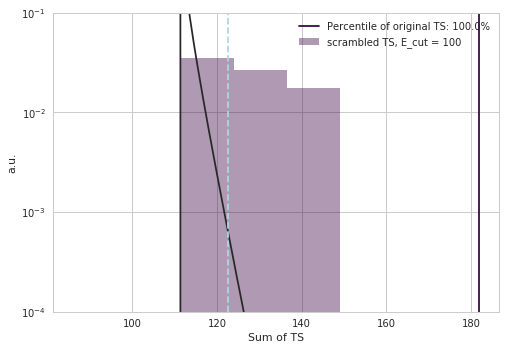

<Figure size 576x396 with 0 Axes>

In [46]:
for ecut in wspot_dict:
    func = scipy.stats.chi2
    plt.figure()
    sns.distplot(wspot_dict[ecut]['scrambling TS'][1:], label="scrambled TS, E_cut = {}".format(ecut), kde=False, fit=func)
    plt.axvline(wspot_dict[ecut]['original TS'], label="Percentile of original TS: {}%".format(result))
    res = func.fit(wspot_dict[ecut]['scrambling TS'][1:])
    plt.axvline(func.isf(erfc(3./np.sqrt(2))*0.5, *res), ls="--", color="lightblue")
    plt.xlabel("Sum of TS")
    plt.ylabel("a.u.")
    plt.legend()
    plt.ylim(1e-4, 1e-1)
    plt.semilogy(nonposy="clip")
        